# Tutorial for batch processing in `expsolve`

By batch processing we mean Single Instruction Multiple Data (SIMD), i.e. computing the same action on multiple different data. Batch processing is built-in in `expsolve` from ground up. 

The tutorials in this folder provide examples on how to use it in practice.

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt

import expsolve as es
import expsolve.discretize.tensorgrid as ex
import expsolve.evolve.splittings.classical as split

import torch
from torch import exp, sin, cos, abs, real, imag, pi
from torch.linalg import matrix_exp

In [3]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
device

device(type='cuda')

We create a batch of 4 functions:

$$ \sin(x), \quad \cos(x), \quad \exp(\sin(x)), \quad \cos(x) \exp(\cos(x))$$

We use `torch.stack` to create a tensor out of a list of these function values. 

`ex.plot` can now plot all these functions, but we pass an extra parameter `separatelines=True`. More details are available in the notebook `02_visualization.ipynb`.

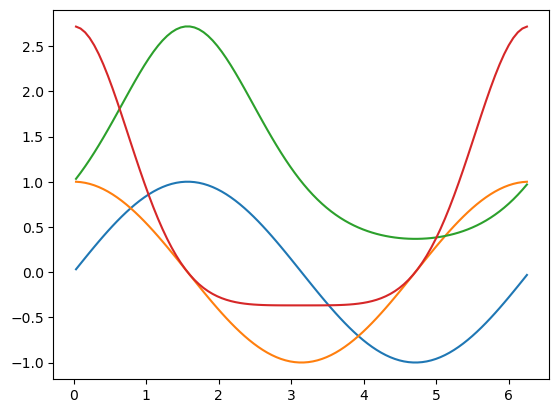

torch.Size([4, 100])


In [6]:
xrange = [0, 2*np.pi]
n = 100
x = ex.grid1d(n, xrange).to(device)     # this ensures everything ends up on the appropriate device!

fns = [sin, cos, lambda x: exp(sin(x)), lambda x: cos(x)*exp(cos(x))]
f = torch.stack([f(x).flatten() for f in fns])

plt.figure()
ex.plot(plt, x, f, separatelines=True)
plt.show()

print(f.shape)


Note that the shape of `f` is `[4, 100]` since it has 4 functions with 100 grid point values.

We can differentiate all of these functions together using `diffop` in a batch parallel way without looping through each function individually. The syntax for `diffop` does not change at all. 

Here are the first and second derivatives of these functions:

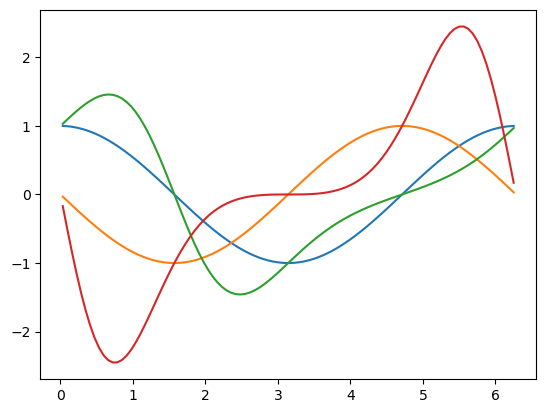

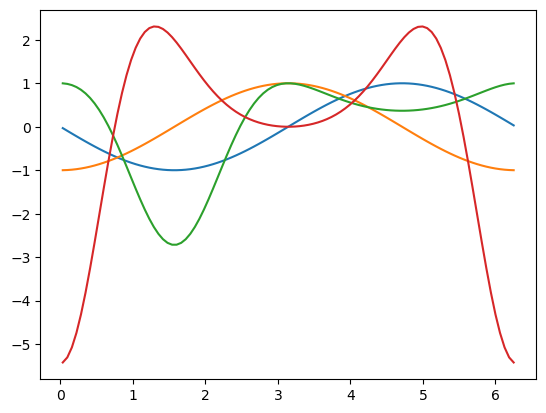

In [7]:
df = real(ex.diffop(0,1,f,xrange))
d2f = real(ex.diffop(0,2,f,xrange))

plt.figure()
ex.plot(plt, x, df, separatelines=True)
plt.show()

plt.figure()
ex.plot(plt, x, d2f, separatelines=True)
plt.show()

### Randomized functions

torch.Size([3, 100])


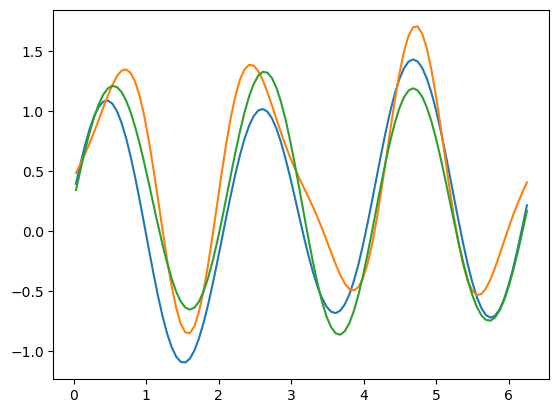

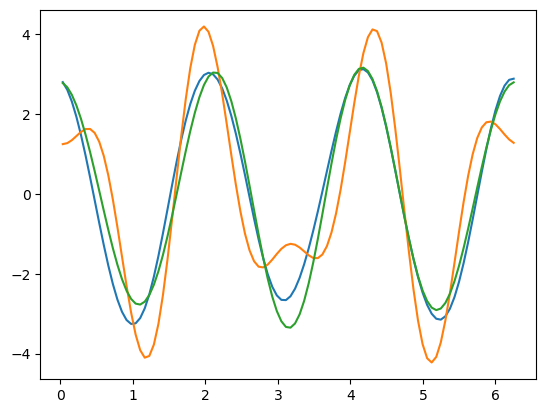

In [6]:
N = 3

# random, periodic functions
def randomf():
    # q real, p int
    p = np.random.randint(low=-5, high=5, size=4)
    q = np.random.normal(loc=0.2, scale=0.1, size=5)
    return sin(3*x) + q[0]*sin(p[0]*x) + q[1]*exp(q[2]*sin(p[1]*x)) + q[3]*cos(p[2]*x)*exp(q[4]*cos(p[3]*x))

fr = torch.stack([randomf().flatten() for _ in range(N)])


plt.figure()
ex.plot(plt, x, fr, separatelines=True)
dfr = real(ex.diffop(0,1,fr,xrange))
print(dfr.shape)

plt.figure()
ex.plot(plt, x, dfr, separatelines=True)
plt.show()


### Advantage of batch parallelization

In [7]:
N = 10000
frlist = [randomf() for _ in range(N)]
frtensor = torch.stack([fr.flatten() for fr in frlist])

tim1 = time.time()
dfrtensor = real(ex.diffop(0,1,frtensor,xrange))
tim2 = time.time()
tim_batch = tim2-tim1
print(f'Batch of size {N} took {tim_batch}s')


tim1 = time.time()
for fr in frlist:
    dfr = real(ex.diffop(0,1,fr,xrange))
tim2 = time.time()
tim_loop = tim2-tim1
print(f'Loop of size {N} took {tim_loop}s')

print(f'Speed up factor {tim_loop/tim_batch:.2f} on {device}')


Batch of size 10000 took 0.004999637603759766s
Loop of size 10000 took 7.589214086532593s
Speed up factor 1517.95 on cuda
